In [1]:
# based on https://github.com/hep-lbdl/OmniFold/GaussianExample.ipynb

# Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import norm

import uproot
import pandas as pd

print(tf.__version__, uproot.__version__)

2024-09-11 20:18:33.635829: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-11 20:18:33.643638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 20:18:33.652130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 20:18:33.654713: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-11 20:18:33.662216: I tensorflow/core/platform/cpu_feature_guar

2.17.0 5.3.12


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1726103914.400038  440148 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726103914.424177  440148 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726103914.424305  440148 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


# Loading numuCC Data

In [8]:
# MicroBooNE Run 3 NuWro Fake Data with WC Reconstruction

bdt_vars = [
    "nue_score",
    "numu_score",
    "numu_cc_flag"
]

eval_vars = [
    "truth_nuEnergy",
    "truth_nuPdg",
    "truth_isCC",
    "truth_vtxInside",
    "match_isFC",
    "match_completeness_energy",
    "truth_energyInside",
    "weight_cv",
    "weight_spline",
]

eval_data_vars = [
    "match_isFC",
    "pl_true_nu_energy", 
    "pl_true_lep_energy",
    "pl_interaction_type",
]

kine_vars = [
    "kine_reco_Enu",
]

pf_vars = [
    "reco_muonMomentum",
    "truth_muonMomentum",
]

pf_data_vars = [
    "reco_muonMomentum",
]


f = uproot.open("data/checkout_prodgenie_bnb_nu_overlay_run3_PF.root")["wcpselection"]
f_bdt = f["T_BDTvars"].arrays(bdt_vars, library="pd")
f_eval = f["T_eval"].arrays(eval_vars, library="pd")
f_kine = f["T_KINEvars"].arrays(kine_vars, library="pd")
f_pfeval = f["T_PFeval"].arrays(pf_vars, library="pd")
overlay_POT = np.sum(f["T_pot"].arrays("pot_tor875good", library="np")["pot_tor875good"])
overlay_df = pd.concat([f_bdt, f_eval, f_kine, f_pfeval], axis=1, sort=False)
del f
del f_bdt
del f_eval
del f_kine
del f_pfeval

f = uproot.open("data/checkout_prodnuwro_overlay_run3_PF.root")["wcpselection"]
f_bdt = f["T_BDTvars"].arrays(bdt_vars, library="pd")
f_eval = f["T_eval"].arrays(eval_data_vars, library="pd")
f_kine = f["T_KINEvars"].arrays(kine_vars, library="pd")
f_pfeval = f["T_PFeval"].arrays(pf_data_vars, library="pd")
fake_data_POT = np.sum(f["T_pot"].arrays("pot_tor875good", library="np")["pot_tor875good"])
fake_data_df = pd.concat([f_bdt, f_eval, f_kine, f_pfeval], axis=1, sort=False)
del f
del f_bdt
del f_eval
del f_kine
del f_pfeval


FileNotFoundError: [Errno 2] No such file or directory: '/home/lee/ml_projects/lartpc_omnifold/data/checkout_prodgenie_bnb_nu_overlay_run3_PF.root'

In [ ]:
weight_cv_vals = overlay_df["weight_cv"].to_numpy()
weight_spline_vals = overlay_df["weight_spline"].to_numpy()
net_weights = []
for i in range(len(weight_cv_vals)):
    weight_cv = weight_cv_vals[i]
    weight_spline = weight_spline_vals[i]
    if not (0 < weight_cv < 30):
        weight_cv = 1
    net_weights.append(weight_cv * weight_spline * fake_data_POT / overlay_POT)

overlay_df["net_weight"] = net_weights


In [ ]:
costheta_vals = []
muonmomentum_vals = []
reco_muonmomentum_x = [x[0] for x in overlay_df["reco_muonMomentum"].to_numpy()]
reco_muonmomentum_y = [x[1] for x in overlay_df["reco_muonMomentum"].to_numpy()]
reco_muonmomentum_z = [x[2] for x in overlay_df["reco_muonMomentum"].to_numpy()]
reco_muonmomentum_t = [x[3] for x in overlay_df["reco_muonMomentum"].to_numpy()]
for i in range(len(reco_muonmomentum_x)):
    if reco_muonmomentum_t[i] < 105.66 / 1000.: # surprising that this happens for positive values, but I did find some events
        costheta_vals.append(-1)
        muonmomentum_vals.append(-1)
    else:
        costheta_vals.append(reco_muonmomentum_z[i] / np.sqrt(reco_muonmomentum_x[i]**2 + reco_muonmomentum_y[i]**2 + reco_muonmomentum_z[i]**2))
        muon_KE = reco_muonmomentum_t[i] * 1000. - 105.66
        muonmomentum_vals.append(np.sqrt(muon_KE**2 + 2 * muon_KE * 105.66))
overlay_df["reco_costheta"] = costheta_vals
overlay_df["reco_muon_momentum"] = muonmomentum_vals

costheta_vals = []
muonmomentum_vals = []
reco_muonmomentum_x = [x[0] for x in fake_data_df["reco_muonMomentum"].to_numpy()]
reco_muonmomentum_y = [x[1] for x in fake_data_df["reco_muonMomentum"].to_numpy()]
reco_muonmomentum_z = [x[2] for x in fake_data_df["reco_muonMomentum"].to_numpy()]
reco_muonmomentum_t = [x[3] for x in fake_data_df["reco_muonMomentum"].to_numpy()]
for i in range(len(reco_muonmomentum_x)):
    if reco_muonmomentum_t[i] < 105.66 / 1000.: # surprising that this happens for positive values, but I did find some events
        costheta_vals.append(-1)
        muonmomentum_vals.append(-1)
    else:
        costheta_vals.append(reco_muonmomentum_z[i] / np.sqrt(reco_muonmomentum_x[i]**2 + reco_muonmomentum_y[i]**2 + reco_muonmomentum_z[i]**2))
        muon_KE = reco_muonmomentum_t[i] * 1000. - 105.66
        muonmomentum_vals.append(np.sqrt(muon_KE**2 + 2 * muon_KE * 105.66))
fake_data_df["reco_costheta"] = costheta_vals
fake_data_df["reco_muon_momentum"] = muonmomentum_vals

overlay_df["true_muon_momentum_3"] = [_[3] * 1000. for _ in overlay_df["truth_muonMomentum"].to_numpy()]
overlay_df["true_muon_KE"] = overlay_df["true_muon_momentum_3"].to_numpy() - 105.66
overlay_df["true_muon_momentum"] = np.sqrt(overlay_df["true_muon_KE"]**2 + 2*overlay_df["KE_muon"] * 105.66)

sig_query = "match_completeness_energy>0.1*truth_energyInside and truth_nuPdg==14 and truth_isCC==1 and truth_vtxInside==1 and true_muon_momentum_3>0 and truth_nuEnergy<=4000 and truth_nuEnergy > 200 and true_muon_momentum > 0 and true_muon_momentum <= 2500"
sel_query = "numu_cc_flag >= 0 and numu_score > 0.9 and nue_score < 7 and reco_muon_momentum>0"
overlay_df["wc_numuCC_selected"] = overlay_df.eval(sel_query)
overlay_df["wc_numuCC_sig"] = overlay_df.eval(sig_query)
fake_data_df["wc_numuCC_selected"] = fake_data_df.eval(sel_query)


fake_data_df["true_muon_energy"] = fake_data_df["pl_true_lep_energy"] * 1000.
fake_data_df["true_muon_KE"] = fake_data_df["pl_true_lep_energy"] * 1000.
fake_data_df["true_muon_momentum"] = np.sqrt(fake_data_df["true_muon_KE"]**2 + 2*fake_data_df["true_muon_KE"] * 105.66)


simple_overlay_df = overlay_df[["wc_numuCC_selected", "wc_numuCC_sig", "truth_nuEnergy", "true_muon_momentum", "reco_muon_momentum", "net_weight"]]
simple_fake_data_df = fake_data_df[["wc_numuCC_selected", "reco_muon_momentum", "true_muon_momentum"]]



In [ ]:
simple_overlay_df

,wc_numuCC_selected,wc_numuCC_sig,truth_nuEnergy,true_muon_momentum,reco_muon_momentum,net_weight
0,True,True,1489.831421,372.721672,158.143884,0.548481
1,False,True,728.165955,244.613543,-1.000000,0.548481
2,False,False,710.893616,148.818567,-1.000000,0.548481
3,False,False,1149.019531,649.785399,-1.000000,0.611907
4,False,False,889.859497,-1000.000000,-1.000000,0.548481
...,...,...,...,...,...,...
581936,False,False,797.798584,-1000.000000,-1.000000,0.548481
581937,False,False,2494.067383,2324.522495,-1.000000,0.624583
581938,False,False,235.531815,-1000.000000,-1.000000,0.548481
581939,False,False,796.507874,385.296017,-1.000000,0.659145


In [ ]:
simple_fake_data_df

,wc_numuCC_selected,reco_muon_momentum
0,False,-1.000000
1,False,-1.000000
2,True,365.635086
3,False,-1.000000
4,False,-1.000000
...,...,...
245206,False,-1.000000
245207,False,-1.000000
245208,False,-1.000000
245209,False,-1.000000


# Plotting True and Reco

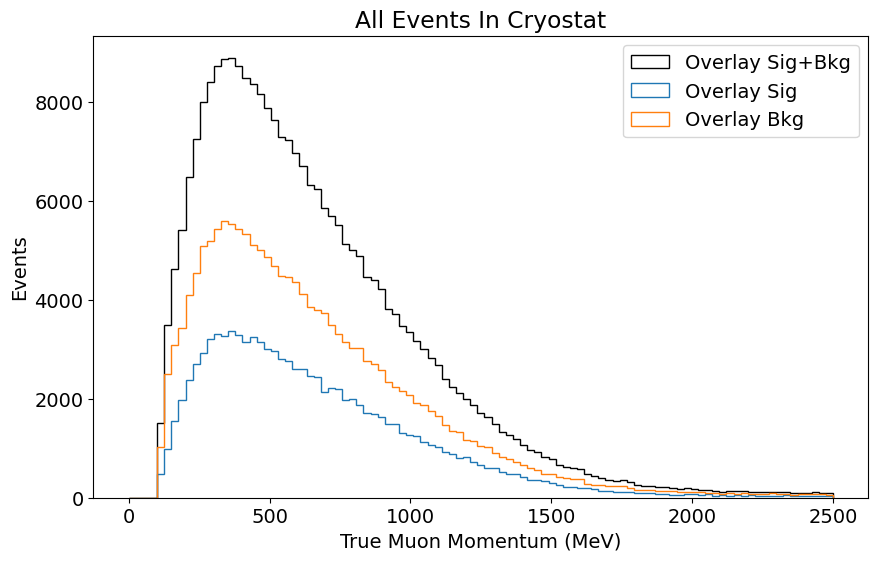

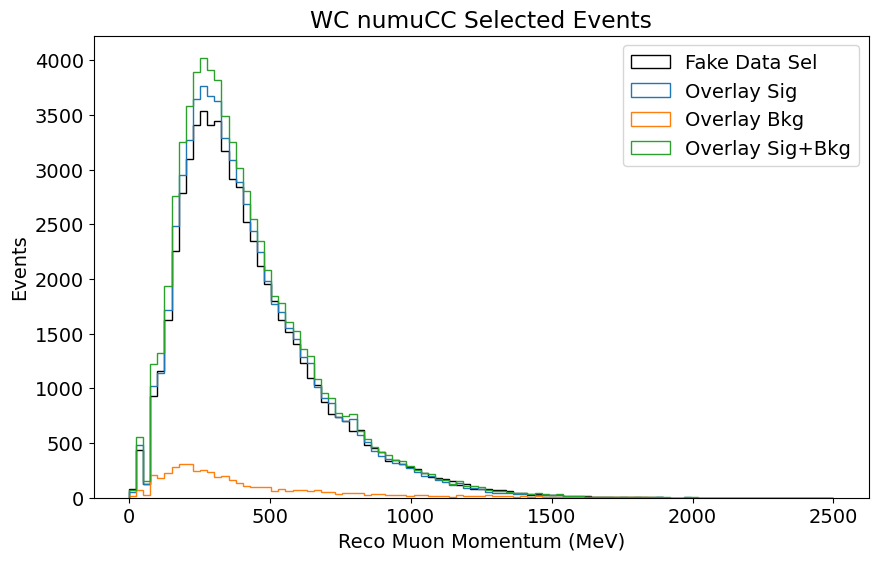

In [ ]:
bins = np.linspace(0, 2500, 100)

overlay_sig_df = simple_overlay_df.query("wc_numuCC_sig==1")
overlay_bkg_df = simple_overlay_df.query("wc_numuCC_sig==0")
overlay_sel_df = simple_overlay_df.query("wc_numuCC_selected==1")
overlay_sig_sel_df = overlay_sig_df.query("wc_numuCC_selected==1")
overlay_bkg_sel_df = overlay_bkg_df.query("wc_numuCC_selected==1")

fake_data_sel_df = simple_fake_data_df.query("wc_numuCC_selected==1")

plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(10, 6))
plt.hist(simple_overlay_df["true_muon_momentum"], weights=simple_overlay_df["net_weight"], bins=bins, histtype="step", label="Overlay Sig+Bkg", color="k")
plt.hist(overlay_sig_df["true_muon_momentum"], weights=overlay_sig_df["net_weight"], bins=bins, histtype="step", label="Overlay Sig")
plt.hist(overlay_bkg_df["true_muon_momentum"], weights=overlay_bkg_df["net_weight"], bins=bins, histtype="step", label="Overlay Bkg")
plt.xlabel("True Muon Momentum (MeV)")
plt.ylabel("Events")
plt.legend()
plt.title("All Events In Cryostat")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(fake_data_sel_df["reco_muon_momentum"], bins=bins, histtype="step", label="Fake Data Sel", color="k")
plt.hist(overlay_sig_sel_df["reco_muon_momentum"], weights=overlay_sig_sel_df["net_weight"], bins=bins, histtype="step", label="Overlay Sig")
plt.hist(overlay_bkg_sel_df["reco_muon_momentum"], weights=overlay_bkg_sel_df["net_weight"], bins=bins, histtype="step", label="Overlay Bkg")
plt.hist(overlay_sel_df["reco_muon_momentum"], weights=overlay_sel_df["net_weight"], bins=bins, histtype="step", label="Overlay Sig+Bkg")
plt.xlabel("Reco Muon Momentum (MeV)")
plt.ylabel("Events")
plt.legend()
plt.title("WC numuCC Selected Events")
plt.show()
